# FEM for the strongly damped wave equation

This script shows the performance of standard FEM on the strongly damped wave equation with smooth coefficients. The coefficients are set as $A(x) = B(x) = 1$, and a reference solution is computed on a fine mesh with $1/h = 4096$. The source term is $f(x,t) = 2(t+1)$, and the analytical solution to this problem is given by $u(x,t) = tx(1-x)$.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from gridlod import util, fem
from gridlod.world import World
import femsolverCoarseWave

'''
Settings
'''

fine = 4096
NFine = np.array([fine])
NpFine = np.prod(NFine + 1)
NList = [2, 4, 8, 16, 32, 64, 128, 256]

# fine grid nodes
pi = np.pi
xt = util.tCoordinates(NFine).flatten()
xp = util.pCoordinates(NFine).flatten()

# time step parameters
tau = 0.01
numTimeSteps = 100

# coefficients A, B
aFine = np.ones(NpFine - 1)
bFine = np.ones(NpFine - 1)

# store exact solution
uSol = []
for i in xrange(numTimeSteps):
    t = tau * (i + 1)
    uSol.append(t * xp * (1 - xp))


# lists for plots
solutions = []
xpCoarseList = []
error = []
x = []
y = []

for N in NList:

    # create world settings
    NWorldCoarse = np.array([N])
    boundaryConditions = np.array([[0, 0]])
    NCoarseElement = NFine/NWorldCoarse
    world = World(NWorldCoarse, NCoarseElement, boundaryConditions)

    # coarse grid nodes
    xpCoarse = util.pCoordinates(NWorldCoarse).flatten()
    xpCoarseList.append(xpCoarse)
    NpCoarse = np.prod(NWorldCoarse + 1)

    # lists for storage
    f = [0]
    Uo = np.zeros(NpCoarse)
    Vo = xpCoarse * (1 - xpCoarse)
    U = [Uo]
    V = [Vo]
    AFine = fem.assemblePatchMatrix(NFine, world.ALocFine, aFine)

    # coarse solution for each time step
    for i in xrange(numTimeSteps):
        t = tau * (i + 1)
        f.append(2 * (t + 1) * np.ones(NpFine))
        uCoarseFull = femsolverCoarseWave.solveCoarse_fem(world, aFine, bFine, f[i + 1], U[i], V[i], tau,
                                                          boundaryConditions)
        U.append(uCoarseFull)
        V.append((U[i + 1] - U[i]) / tau)

    # append solution for this mesh size
    solutions.append(U)

    # append L2-error (at final time step)
    basis = fem.assembleProlongationMatrix(NWorldCoarse, NCoarseElement)
    uLodCoarse = basis * uCoarseFull
    error.append(np.sqrt(np.dot((uSol[-1] - uLodCoarse), (uSol[-1] - uLodCoarse))))
    x.append(N)
    y.append(1. / N ** 2)

Plot the approximate solutions next to the reference solution.

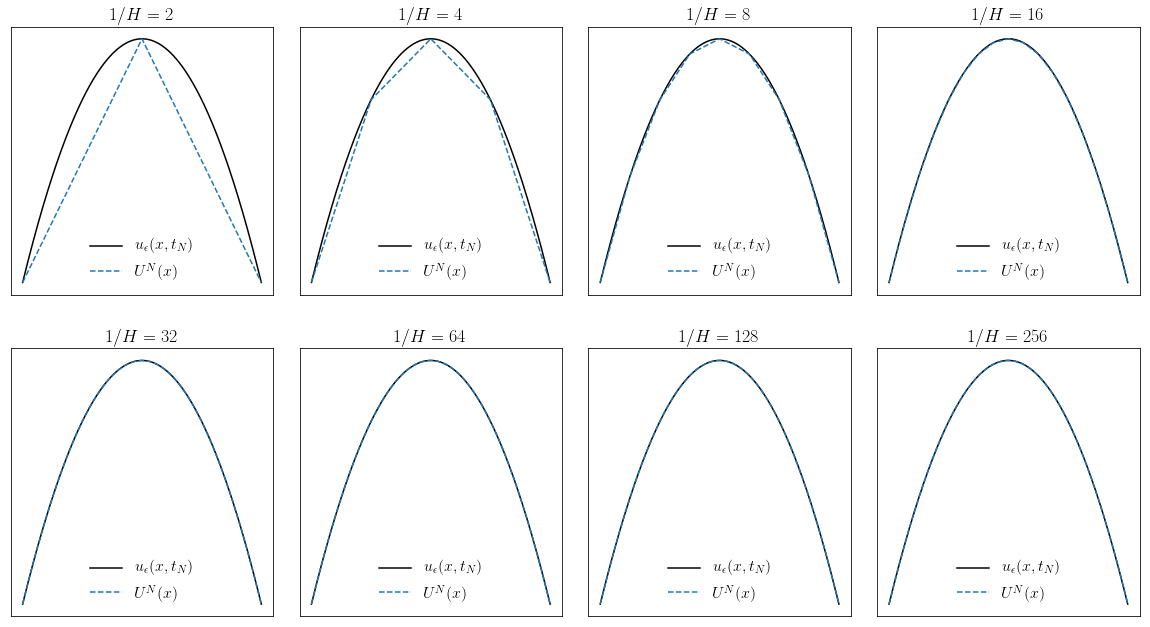

In [4]:
#Plot solutions
plt.figure('FEM-Solutions', figsize=(16, 9))
plt.subplots_adjust(left=0.01, bottom=0.04, right=0.99, top=0.95, wspace=0.1, hspace=0.2)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
for i in xrange(len(NList)):
    plt.subplot(2,4,i+1)
    plt.plot(xp, uSol[-1], 'k', label=r'$u_\epsilon(x,t_N)$')
    plt.plot(xpCoarseList[i], solutions[i][-1], '--', label=r'$U^N(x)$')
    plt.title(r'$1/H=$ ' + str(2**(i+1)), fontsize=18)
    plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off',
                    labelleft='off')
    plt.legend(frameon=False, fontsize=16)
plt.show()

Plot the $L^2$-error for different mesh widths.

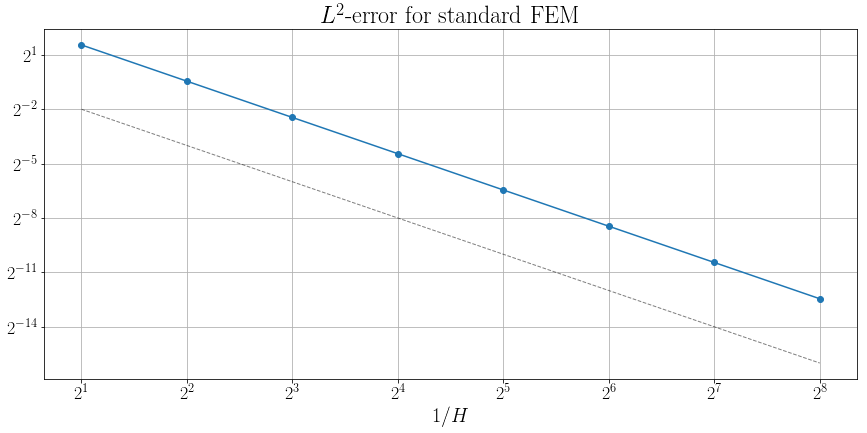

In [6]:
# plot errors
plt.figure("Error", figsize=(12,6))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.subplots_adjust(left=0.05, bottom=0.11, right=0.99, top=0.92, wspace=0.1, hspace=0.2)
plt.tick_params(labelsize=18)
plt.loglog(x,error,'o-', basex=2, basey=2)
plt.loglog(x,y,'--k',basex=2, basey=2, linewidth=1, alpha=0.5)
plt.xlabel(r'$1/H$', fontsize=20)
plt.title(r'$L^2$-error for standard FEM', fontsize=24)
plt.grid(True,which="both")
plt.show()